In [11]:
from groundedPL.codificacion import ToPropositionalLogic

parser = ToPropositionalLogic()
parser.debug = False

In [ ]:
from groundedPL.logUtils import LogUtils
NUM_FILAS = 8
NUM_COLUMNAS = 8
casillas = [(f"fila{x}, {x2}", f"columna{y}, {y2}")
            for x in range(NUM_FILAS) for y in range(NUM_COLUMNAS)
            for x2 in range(NUM_FILAS) for y2 in range(NUM_COLUMNAS)]

def crear_regla_1():
    #Bn: Barco de n casillas (n=1,2,3,4)
    otoria_Bn = []
    for n in range(1, 5):
        for x in range(NUM_FILAS):
            for y in range(NUM_COLUMNAS):
                for i in range(n):
                    x2, y2 = x + i, y
                    if x2 < NUM_FILAS:
                        atomo = parser.to_nltk(f"EN({x},{y}, {x2},{y2})")
                        otoria_Bn.append(atomo)
                for j in range(n):
                    x2, y2 = x, y + j
                    if y2 < NUM_COLUMNAS:
                        atomo = parser.to_nltk(f"EN({x},{y}, {x2},{y2})")
                        otoria_Bn.append(atomo)
    # B1: Barco de 1 casilla 
    otoria_B1 = []
    for x in range(8):
        for y in range(8):
            x2, y2 = x, y
            atomo = parser.to_nltk(f"EN({x},{y}, {x},{y})")
            otoria_B1.append(atomo)
    B1 = LogUtils.Otoria(otoria_B1)

    # B2: Barco de 2 casillas (horizontal o vertical)
    otoria_B2_h = []
    for x in range(7):
        ytoria = []
        for y in range(8):
            x2, y2 = x + 1, y
            ytoria.append(parser.to_nltk(f"EN(({x},{y}), ({x2},{y2}))"))
        otoria_B2_h.append(LogUtils.Ytoria(ytoria))
    
    otoria_B2_v = []
    for y in range(7):
        ytoria = []
        for x in range(8):
            x2, y2 = x, y + 1 

            ytoria.append(any.nltk_log_parser.parse(f"EN(({x},{y}), ({x2},{y2}))"))
        otoria_B2_v.append(LogUtils.Ytoria(ytoria))
    
    B2 = LogUtils.Otoria(otoria_B2_h + otoria_B2_v)

    # B3: Barco de 3 casillas (horizontal o vertical)
    otoria_B3_h = []
    for x in range(7):
        ytoria = []
        for y in range(8):
            x2, y2 = x + 2, y           
            ytoria.append(any.nltk_log_parser.parse(f"EN(({x},{y}), ({x2},{y2}))"))
        otoria_B3_h.append(LogUtils.Ytoria(ytoria))
    
    otoria_B3_v = []
    for y in range(7):
        ytoria = []
        for x in range(8):
            x2, y2 = x, y + 2
            ytoria.append(any.nltk_log_parser.parse(f"EN(({x},{y}), ({x2},{y2}))"))
        otoria_B3_v.append(LogUtils.Ytoria(ytoria))
    B3 = LogUtils.Otoria(otoria_B3_h + otoria_B3_v)
    
    # B4: Barco de 4 casillas (horizontal o vertical)
    otoria_B4_h = []
    for x in range(7):
        ytoria = []
        for y in range(8):
            x2, y2 = x + 3, y
            ytoria.append(any.nltk_log_parser.parse(f"EN(({x},{y}), ({x2},{y2}))"))
        otoria_B4_h.append(LogUtils.Ytoria(ytoria))
    
    otoria_B4_v = []
    for y in range(7):
        ytoria = []
        for x in range(8):
            x2, y2 = x, y + 3
            ytoria.append(any.nltk_log_parser.parse(f"EN(({x},{y}), ({x2},{y2}))"))
        otoria_B4_v.append(LogUtils.Ytoria(ytoria))
    
    B4 = LogUtils.Otoria(otoria_B4_h + otoria_B4_v)

    # Combinar todas las condiciones
    regla_1 = LogUtils.Ytoria([B1, B2, B3, B4])
    return any.codificar_lp(regla_1)

# Definir barcos (hardcodeados como en tu ejemplo)
barcos = {
    'Bn' :[("fila0", "columna0"), ("fila0", "columna0")],
    'Bn' :[("fila1", "columna0"), ("fila1", "columna1")],
    #'B1': [("fila0", "columna0"), ("fila0", "columna0")],
    #'B2': [("fila1", "columna0"), ("fila1", "columna1")],
    'B3': [("fila2", "columna0"), ("fila2", "columna1"), ("fila2", "columna2")],
    'B4': [("fila3", "columna0"), ("fila3", "columna1"), ("fila3", "columna2"), ("fila3", "columna3")]
}

# Función para imprimir barcos y casillas vacías
def imprimir_estado(barcos, casillas):
    for nombre, posiciones in barcos.items():
        print(f"\n{nombre}:")
        print(f"{nombre} definido entre {', '.join([f'({x1},{y1})' 
                                                    for x1, y1 in posiciones])}")
                                                    #for x2, y2 in posiciones])}")
    
    casillas_ocupadas = [pos for posiciones in barcos.values() for pos in posiciones]
    casillas_vacias = [f"¬BARCO({x}, {y})" for x, y in casillas if (x, y) not in casillas_ocupadas]
    
    print("\nCasillas vacías:")
    print(casillas_vacias)

#adyacentes = [(f"fila{x}", f"columna{y}") for x in range(8) for y in range(8)]
imprimir_estado(barcos, casillas)



Bn:
Bn definido entre (fila1,columna0), (fila1,columna1)

B3:
B3 definido entre (fila2,columna0), (fila2,columna1), (fila2,columna2)

B4:
B4 definido entre (fila3,columna0), (fila3,columna1), (fila3,columna2), (fila3,columna3)

Casillas vacías:
['¬BARCO(fila0, 0, columna0, 0)', '¬BARCO(fila0, 0, columna0, 1)', '¬BARCO(fila0, 0, columna0, 2)', '¬BARCO(fila0, 0, columna0, 3)', '¬BARCO(fila0, 0, columna0, 4)', '¬BARCO(fila0, 0, columna0, 5)', '¬BARCO(fila0, 0, columna0, 6)', '¬BARCO(fila0, 0, columna0, 7)', '¬BARCO(fila0, 1, columna0, 0)', '¬BARCO(fila0, 1, columna0, 1)', '¬BARCO(fila0, 1, columna0, 2)', '¬BARCO(fila0, 1, columna0, 3)', '¬BARCO(fila0, 1, columna0, 4)', '¬BARCO(fila0, 1, columna0, 5)', '¬BARCO(fila0, 1, columna0, 6)', '¬BARCO(fila0, 1, columna0, 7)', '¬BARCO(fila0, 2, columna0, 0)', '¬BARCO(fila0, 2, columna0, 1)', '¬BARCO(fila0, 2, columna0, 2)', '¬BARCO(fila0, 2, columna0, 3)', '¬BARCO(fila0, 2, columna0, 4)', '¬BARCO(fila0, 2, columna0, 5)', '¬BARCO(fila0, 2, columna0,

In [34]:

x, y = range(NUM_FILAS), range(NUM_COLUMNAS)
x2, y2 = range(NUM_FILAS), range(NUM_COLUMNAS)


NameError: name 'NUM_COLUMNAS' is not defined

In [ ]:


formula = f'EN({x}, {y}, {x2}, {y2})'
formula1 = f'Ocupado({x}, {y}) & Ocupado({x2}, {y2}) -> EN({x}, {y}) & EN({x2}, {y2})'
parser.parse(formula)
parser.parse(formula1)




'((ĩ∧Ž)>(Ĩ∧ż))'

---

# Interpretaciones y descriptores <a class="anchor" id="interp"></a>

([Volver al inicio](#inicio))



**Nota:** El orden de los items en el diccionario no siempre guarda correspondencia con el orden de creación.

### Ejercicio 2:

Cree una interpretación que represente una situación apropiada para el problema que está trabajando en su proyecto.

In [58]:
parser.debug = False
# Crear un diccionario para representar las posiciones ocupadas por los barcos
I = {
    parser.parse(f"EN({fila}, {columna})"): (fila, columna) in [pos for posiciones in barcos.values() for pos in posiciones]
    for fila, columna in adyacentes
}


# Mostrar el resultado
for formula, Ocupado in I.items():
    print(f"{formula} : {Ocupado}")

ˍ : True
҆ : False
ؿ : False
߸ : False
঱ : False
୪ : False
ണ : False
ໜ : False
Ί : True
Ճ : True
ۼ : False
ࢵ : False
੮ : False
ధ : False
෠ : False
ྙ : False
Ο : True
՘ : True
ܑ : True
࣊ : False
ઃ : False
఼ : False
෵ : False
ྮ : False
δ : True
խ : True
ܦ : True
ࣟ : True
ઘ : False
౑ : False
ช : False
࿃ : False
ω : False
ւ : False
ܻ : False
ࣴ : False
ભ : False
౦ : False
ฟ : False
࿘ : False
Ϟ : False
֗ : False
ݐ : False
उ : False
ૂ : False
౻ : False
ิ : False
࿭ : False
ϳ : False
֬ : False
ݥ : False
ञ : False
૗ : False
ಐ : False
้ : False
ဂ : False
Ј : False
ׁ : False
ݺ : False
ळ : False
૬ : False
ಥ : False
๞ : False
ဗ : False


In [7]:
parser.debug = False
# Crear un diccionario para representar las posiciones ocupadas por los barcos
OC = {
    parser.parse(f"Ocupado({x1}, {y1}) & Ocupado({x2}, {y2}) -> EN({x1}, {y1}) & EN({x2}, {y2})"): (x2, y2) in [pos for posiciones in barcos.values() for pos in posiciones]
    for (x1, y1) in adyacentes for (x2, y2) in adyacentes
}

for formula, ocupado in OC.items():
    print(f"{formula} : {ocupado}")

((Ϗ∧Ϗ)>(ώ∧ώ)) : True
((Ϗ∧ʋ)>(ώ∧ʊ)) : False
((Ϗ∧ٗ)>(ώ∧ٖ)) : False
((Ϗ∧ޛ)>(ώ∧ޚ)) : False
((Ϗ∧ࣟ)>(ώ∧ࣞ)) : False
((Ϗ∧ਣ)>(ώ∧ਢ)) : False
((Ϗ∧୧)>(ώ∧୦)) : False
((Ϗ∧ಫ)>(ώ∧ಪ)) : False
((Ϗ∧э)>(ώ∧ь)) : True
((Ϗ∧̉)>(ώ∧̈)) : True
((Ϗ∧ە)>(ώ∧۔)) : False
((Ϗ∧࠙)>(ώ∧࠘)) : False
((Ϗ∧ढ़)>(ώ∧ड़)) : False
((Ϗ∧ડ)>(ώ∧ઠ)) : False
((Ϗ∧௥)>(ώ∧௤)) : False
((Ϗ∧ഩ)>(ώ∧ന)) : False
((Ϗ∧џ)>(ώ∧ў)) : True
((Ϗ∧̛)>(ώ∧̚)) : True
((Ϗ∧ۧ)>(ώ∧ۦ)) : True
((Ϗ∧ࠫ)>(ώ∧ࠪ)) : False
((Ϗ∧९)>(ώ∧८)) : False
((Ϗ∧ળ)>(ώ∧લ)) : False
((Ϗ∧௷)>(ώ∧௶)) : False
((Ϗ∧഻)>(ώ∧ഺ)) : False
((Ϗ∧ѱ)>(ώ∧Ѱ)) : True
((Ϗ∧̭)>(ώ∧̬)) : True
((Ϗ∧۹)>(ώ∧۸)) : True
((Ϗ∧࠽)>(ώ∧࠼)) : True
((Ϗ∧ঁ)>(ώ∧ঀ)) : False
((Ϗ∧ૅ)>(ώ∧ૄ)) : False
((Ϗ∧ఉ)>(ώ∧ఈ)) : False
((Ϗ∧്)>(ώ∧ൌ)) : False
((Ϗ∧҃)>(ώ∧҂)) : False
((Ϗ∧̿)>(ώ∧̾)) : False
((Ϗ∧܋)>(ώ∧܊)) : False
((Ϗ∧ࡏ)>(ώ∧ࡎ)) : False
((Ϗ∧ও)>(ώ∧঒)) : False
((Ϗ∧૗)>(ώ∧૖)) : False
((Ϗ∧ఛ)>(ώ∧చ)) : False
((Ϗ∧ൟ)>(ώ∧൞)) : False
((Ϗ∧ҕ)>(ώ∧Ҕ)) : False
((Ϗ∧͑)>(ώ∧͐)) : False
((Ϗ∧ܝ)>(ώ∧ܜ)) : False
((Ϗ∧ࡡ)>(ώ∧ࡠ)) : False
((Ϗ∧থ)>(ώ∧ত)) : False
((Ϗ∧૩)>(ώ∧૨)) : Fals

---

# Visualización de interpretaciones <a class="anchor" id="visual"></a>

([Volver al inicio](#inicio))



In [8]:
atomo = list(I.keys())[0]
print(f'{atomo=}')
print(f'Formula: {parser.leer(atomo)}')

atomo='Ş'
Formula: columna2(columna3, fila7)


In [9]:
parser.obtener_argumentos(atomo)

['columna3', 'fila7']

In [10]:
parser.obtener_predicado(atomo)

'columna2'

In [11]:
from typing import Tuple

def obtener_fila_columna(atomo:str) -> Tuple[int, int]:
    fila, columna = parser.obtener_argumentos(atomo)
    num_fila = filas.index(fila)
    num_columna = columnas.index(columna)
    return num_fila, num_columna
    

### Ejercicio 3:

Cree una función de visualización para representar una situación apropiada de su proyecto. Utilice la interpretación desarrollada en el ejercicio 2 como argumento.

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

def visualizar_batalla_naval(barcos):
    fig, tablero = plt.subplots(figsize=(6, 6))
    tablero.set_xlim(0, 8) #Define el limite del tablero 
    tablero.set_ylim(0, 8)
    tablero.set_xticks(range(9))
    tablero.set_yticks(range(9))
    tablero.set_xticklabels(range(0, 9))
    tablero.set_yticklabels(range(0, 9))
    tablero.grid(True, color='black', linewidth=1)
    tablero.set_title("Tablero de Batalla Naval", fontsize=16)
    tablero.set_xlabel("Columnas", fontsize=12)
    tablero.set_ylabel("Filas", fontsize=12)

    # Colores
    agua_color = 'lightblue'
    barco_color = 'darkgray'
    borde_color = 'black'

    # Dibujar todas las casillas como agua primero
    for x in range(8):
        for y in range(8):
            rect = patches.Rectangle(
                (y, x), 1, 1, 
                facecolor=agua_color, 
                edgecolor=borde_color,
                linewidth=1
            )
            tablero.add_patch(rect)

    # Dibujar los barcos según su tamaño
    for nombre, posiciones in barcos.items():
        # Determinar si el barco es horizontal o vertical
        if len(posiciones) > 1:
            primera = posiciones[0]
            ultima = posiciones[-1]
            x1, y1 = int(primera[0].replace("fila", "")), int(primera[1].replace("columna", ""))
            x2, y2 = int(ultima[0].replace("fila", "")), int(ultima[1].replace("columna", ""))
            
            if x1 == x2:  # Barco horizontal
                width = len(posiciones)
                height = 1
                y = y1
            else:  # Barco vertical
                width = 1
                height = len(posiciones)
                y = y1
                
            rect = patches.Rectangle(
                (y, x1), width, height,
                facecolor=barco_color,
                edgecolor=borde_color,
                linewidth=2
            )
            tablero.add_patch(rect)
            
            # Texto con el tamaño del barco
            tablero.text(y + width/2, x1 + height/2, f"{len(posiciones)}",
                    ha='center', va='center', 
                    fontsize=12, color='red')
        else:  # Barco de 1 casilla
            x = int(posiciones[0][0].replace("fila", ""))
            y = int(posiciones[0][1].replace("columna", ""))
            rect = patches.Rectangle(
                (y, x), 1, 1,
                facecolor=barco_color,
                edgecolor=borde_color,
                linewidth=2
            )
            tablero.add_patch(rect)
            tablero.text(y + 0.5, x + 0.5, "1",
                    ha='center', va='center', 
                    fontsize=12, color='red')

    plt.gca().invert_yaxis()  # Para que fila 0 esté arriba
    plt.show()

# Ejemplo de uso con barcos de diferentes tamaños
I = {
    'B1': [("fila5", "columna5")],  # Barco tamaño 1
    'B2': [("fila6", "columna2"), ("fila6", "columna3")],  # Barco tamaño 2 vertical
    'B3': [("fila2", "columna2"), ("fila3", "columna2"), ("fila4", "columna2")],  # Barco tamaño 3 horizontal
    'B4': [("fila0", "columna3"), ("fila0", "columna4"), ("fila0", "columna5"), ("fila0", "columna6")]  # Barco tamaño 4 vertical
}

ModuleNotFoundError: No module named 'matplotlib'

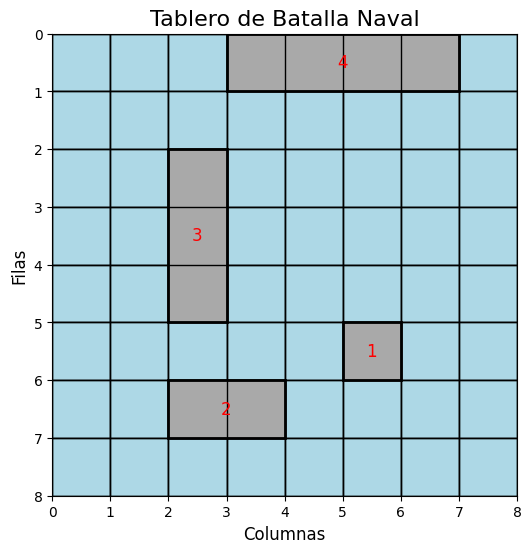

In [ ]:
visualizar_batalla_naval(I)

---